In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import load

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)


e:\fraud-anamoly-detection\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
df = pd.read_csv("../data/processed/transactions_features.csv")

with open("../models/model_features_v1.json") as f:
    FEATURES = json.load(f)["features"]

scaler = load("../models/standard_scaler_v1.pkl")

X = scaler.transform(df[FEATURES])
y_true = df["is_fraud"]

print("Data shape:", X.shape)

Data shape: (100000, 9)


In [4]:
X_normal = X[y_true == 0]
print("Normal samples:", X_normal.shape)

Normal samples: (98962, 9)


In [5]:
input_dim = X_normal.shape[1]

inputs = Input(shape=(input_dim,))
x = Dense(64, activation="relu")(inputs)
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(input_dim)(x)

autoencoder = Model(inputs, outputs)

autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,417 (21.16 KB)

 Trainable params: 5,417 (21.16 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = autoencoder.fit(
    X_normal,
    X_normal,
    epochs=15,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)


Epoch 1/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1401 - val_loss: 0.0052
Epoch 2/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 3/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5661e-04 - val_loss: 8.8475e-04
Epoch 8/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.4841e-04 - val_loss: 8.8827e-04
Epoch 9/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5814e-04 - val_loss: 7.7481e-04
Epoch 10/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.9540e-04 - val_loss: 5.3667e-04
Epoch 11/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1349e-04 - val_loss: 5.5209e-04
Epoch 12/15


In [7]:
X_recon = autoencoder.predict(X)
recon_error = np.mean(np.square(X - X_recon), axis=1)

df["ae_score"] = recon_error

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 840us/step


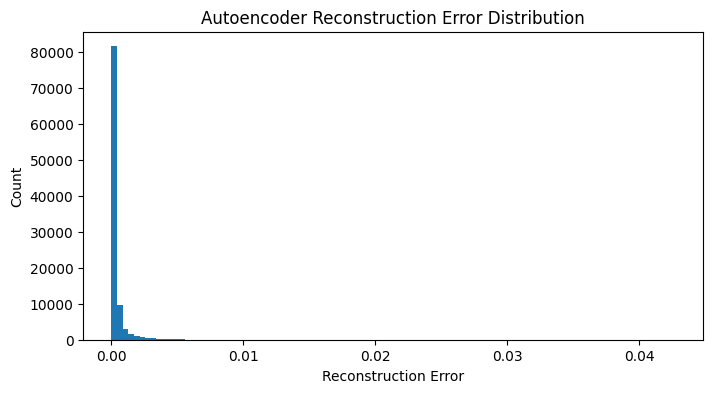

In [8]:
plt.figure(figsize=(8, 4))
plt.hist(recon_error, bins=100)
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()


In [14]:
X_recon = autoencoder.predict(X)
recon_error = np.mean(np.square(X - X_recon), axis=1)

df["ae_score"] = recon_error


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 899us/step


In [15]:
y_pred = df["ae_flag"].astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, df["ae_score"])

print("Autoencoder Metrics")
print("-------------------")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Autoencoder Metrics
-------------------
Precision: 0.0530
Recall:    0.0511
F1-score:  0.0520
ROC-AUC:   0.5925

Confusion Matrix:
[[98015   947]
 [  985    53]]


In [16]:
df.sort_values("ae_score", ascending=False).head(10)[
    FEATURES + ["ae_score", "is_fraud"]
]


,amount_dev_log,avg_amount_24h,txn_count_1h,txn_count_24h,time_since_last_txn_sec,distance_from_home,travel_speed_kmh,hour_sin,hour_cos,ae_score,is_fraud
75200,-6.783146,3434.551818,2.0,11.0,5.430479e+01,7.40,20000.000000,0.965926,-2.588190e-01,0.042720,0
57837,-7.090104,2481.652000,4.0,5.0,2.463696e+02,1169.73,17160.017133,-0.707107,-7.071068e-01,0.038310,0
27003,-6.538366,3489.456250,2.0,8.0,1.546750e+02,7.12,19644.009575,0.707107,-7.071068e-01,0.037907,0
96327,7.032596,2417.382500,3.0,12.0,1.822783e+02,6.71,10069.050896,0.866025,-5.000000e-01,0.029960,0
36318,0.000000,185.640000,1.0,1.0,1.443319e+06,1954.05,4.878439,0.500000,8.660254e-01,0.029284,0
20463,4.349719,324.093333,4.0,12.0,1.255821e+03,1746.11,657.498325,1.000000,6.123234e-17,0.029026,0
79827,0.000000,825.560000,1.0,1.0,5.197157e+06,1823.04,1.256888,-0.258819,-9.659258e-01,0.027985,0
32170,-6.795395,3623.162000,2.0,5.0,1.073197e+02,724.11,20000.000000,0.866025,-5.000000e-01,0.027608,0
70341,4.346702,230.926667,3.0,3.0,2.866396e+00,9.44,20000.000000,0.500000,8.660254e-01,0.026415,0
15556,-2.841220,1247.196667,2.0,3.0,2.938691e+01,6.09,20000.000000,0.500000,8.660254e-01,0.026342,0


since autoencoder flags transactions that deviate from learned normal patterns across multiple dimensions. Many of these anomalies correspond to rare but legitimate behaviors, such as long inactivity followed by distant transactions. This leads to low precision when evaluated against fraud labels, but the model is still valuable for identifying behavioral novelty and supporting downstream risk assessment

In [17]:
# Save autoencoder in native Keras format (Keras 3 recommended)
autoencoder.save("../models/autoencoder_v1.keras")

print("Autoencoder saved in Keras format")


Autoencoder saved in Keras format


The autoencoder is flagging structurally rare but not necessarily fraudulent transactions, such as dormant accounts reactivating at unusual times or locations.

In [22]:
ANOMALY_RATES = [0.005, 0.01, 0.02]

results = []
y_true = df["is_fraud"].values
ae_scores = df["ae_score"].values   # this MUST already exist

for rate in ANOMALY_RATES:
    threshold = np.percentile(ae_scores, 100 * (1 - rate))
    y_pred = (ae_scores >= threshold).astype(int)

    results.append({
        "model": "Autoencoder",
        "anomaly_rate": rate,
        "threshold": threshold,
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, ae_scores)
    })

df_ae_results = pd.DataFrame(results)
df_ae_results

,model,anomaly_rate,threshold,precision,recall,f1,roc_auc
0,Autoencoder,0.005,0.005999,0.0500,0.024085,0.032510,0.592464
1,Autoencoder,0.010,0.003962,0.0530,0.051060,0.052012,0.592464
2,Autoencoder,0.020,0.002824,0.0385,0.074181,0.050691,0.592464


In [23]:
df_ae_results.to_csv("../reports/autoencoder_results.csv", index=False)
print("Saved: reports/autoencoder_results.csv")

Saved: reports/autoencoder_results.csv
